<a href="https://colab.research.google.com/github/gitudaniel/fastai-course-notes/blob/main/Practical_Deep_Learning_for_Coders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Reference [paper](https://www.researchgate.net/publication/339873481_High_Temperature_and_High_Humidity_Reduce_the_Transmission_of_COVID-19)

- Local file: /home/grenouille/Documents/Data Science/fastai_notes/HighTemperatureandHighHumiditynew7_allinOne.pdf

- Practical signicance of results is determined by looking at actual outcomes

- Turning a predictive model into something useful in production [link](https://www.oreilly.com/radar/drivetrain-approach-data-products/)

`P-value` - The probability of an observed result assuming that the null hypothesis is true.

#### Things you should know about P-values

- They can indicate how incompatible the data is with a specified statistical model.
- They do not measure the probability that the studied hypothesis is true, or the probability that the data were produced by random choice alone.
- Scientific conclusions and business or policy decisions should not be based only on whether a p-value passes a specific threshold.
- Proper inference requires full reporting and transparency.
- A p-value, or statistical significance does not measure the size of an effect or the importance of a result.
- By itself, a p-value does not provide a good measure of evidence regarding a model or hypothesis.

#### Getting value from a predictive model

- Think about what you're trying to do and the sources of value for the objective you're trying to achieve.
- What are the things you can change.
- Figure out what data you don't have and ways to get suitable data.
- Figure out approaches to analytics that you can take.
- Can you implement those changes.
- How do you change things as the environment changes.
- What constraints are in place across the entire chain.

In [ ]:
import keys
import os

In [ ]:
# the result of keys.consumer_key is returned as a tuple
os.environ['AZURE_SEARCH_KEY'] = keys.consumer_key[0]

In [ ]:
!pip install fastbook

     |████████████████████████████████| 727kB 7.6MB/s 
     |████████████████████████████████| 194kB 16.5MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 1.2MB 18.4MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import fastbook

fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
from fastai.vision.widgets import *
from fastbook import *

In [ ]:
import os

key = os.environ['AZURE_SEARCH_KEY']

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
mkdir images

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
dest = "images/grizzly.jpg"
download_url(ims[2], dest)

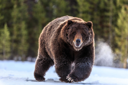

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key,f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#415) [Path('bears/grizzly/00000067.jpg'),Path('bears/grizzly/00000027.jpg'),Path('bears/grizzly/00000060.jpg'),Path('bears/grizzly/00000057.jpg'),Path('bears/grizzly/00000077.jpg'),Path('bears/grizzly/00000126.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000094.jpg'),Path('bears/grizzly/00000141.jpg'),Path('bears/grizzly/00000009.jpg')...]

In [ ]:
# check that all filenames are actual images
failed = verify_images(fns)
failed

(#11) [Path('bears/grizzly/00000077.jpg'),Path('bears/grizzly/00000053.jpg'),Path('bears/grizzly/00000119.jpg'),Path('bears/teddy/00000057.jpg'),Path('bears/teddy/00000120.jpg'),Path('bears/teddy/00000093.jpg'),Path('bears/teddy/00000082.jpg'),Path('bears/teddy/00000050.jpg'),Path('bears/black/00000083.jpg'),Path('bears/black/00000089.jpg')...]

In [ ]:
# for all the failed images delete file
failed.map(Path.unlink);

# Creating a model

- We first tell fastai what kind of data we have and how it's structured using the DataBlock API

In [ ]:
DataBlock

fastai.data.block.DataBlock

In [ ]:
# Tell fastai what kind of data we have and how it's structured
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

#### The DataBlock API

- `blocks` - Declare the independent (input data/ImageBlock -> images) and the dependent (labels/CategoryBlock -> categories: grizzly, black, teddy) variables
- `get_items` - specify the function to use to get the list of items to be processed in this case filenames
- `splitter` - specify how to split the data into a training and validation set.
    - `RandomSplitter` splits the data randomly
    - `valid_pct` declares what portion of data to put into the validation set
    - `seed` makes sure that every time we run this the validation set will be the same
- `get_y` - specify how to label the data
    - `parent_label` looks for each item at the name of the parent folder
- `item_tfms` (item transforms) - Function that get applied to each item in the dataset. In this case resize all images to 128 x 128
- `Resize(128)` - Resize all images to 128 x 128 pixels. By default Resize grabs the center of the image but we can pass custom arguments to perform other operations like squish or stretch.
- `Data Loader` - Grabs a few items at a time and puts them into a batch so that it can pass them all into the model through the GPU at once (default 64)

In [ ]:
# dls -> data loaders
dls = bears.dataloaders(path)

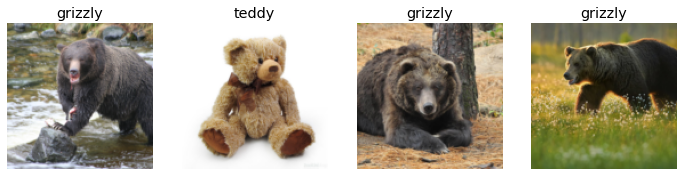

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

- `bears.new()` creates a copy of our bears DataBlock object where we can then change just some pieces

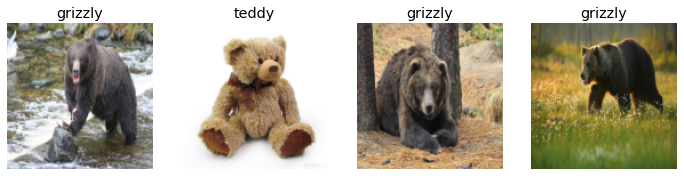

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

- for the Resize method, we can add a bit of padding to make the images look more realistic
- `pad_mode='zeros'` means pad it with black bars

- The pad method is the most efficient since we end up with the correct size and all of the pixels. But you also end up with wasted pixels

- The squish method is the most efficient since you end up with all of the information and nothing is wasted but on the downside, the neural net will have to learn when something's been squished.

- The default cropping approach actually removes some information from the image.

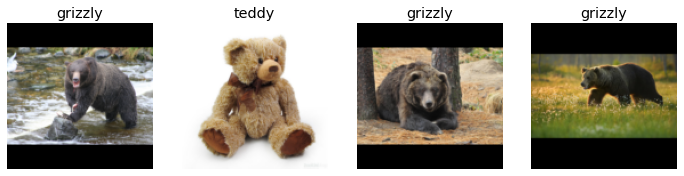

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

- We can use `RandomResizedCrop` instead of `Resize` which is the most common approach.
- `RandomResizedCrop` grabs a different part of the image and zooms into it each time.
- `Data Augmentation` - making it such that each time the model sees the image it looks a little bit different.
- Data augmentation makes the model less likely to overfit but we might lose a lot of information from the image.
- `min_scale=0.3` means we're going to at least pick 30% of the original image pixels each time and zoom into that square. 

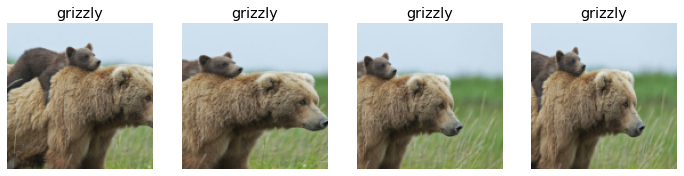

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

- The best way to do data augmentation is to use `aug_transforms` which returns a list of different augmentations as can be seen below.

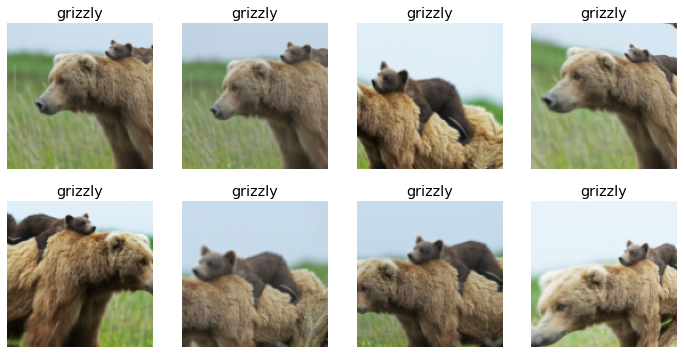

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training your model

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=fastbook.aug_transforms())

dls = bears.dataloaders(path)

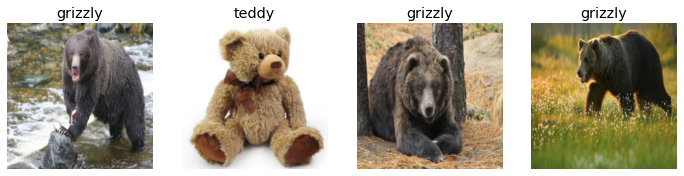

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.556340,0.491115,0.247934,01:21


epoch,train_loss,valid_loss,error_rate,time
0,0.178183,0.362222,0.157025,01:52
1,0.127704,0.493404,0.157025,01:39
2,0.099473,0.608612,0.190083,01:38
3,0.078131,0.655268,0.206612,01:38


- Our error rate reduces after training for roughly 4 minutes

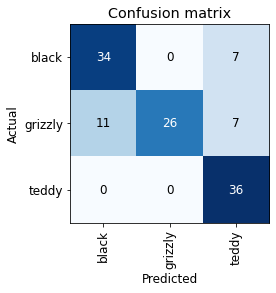

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

- We only have 1 error a black bear that was predicted to be a grizzly bear

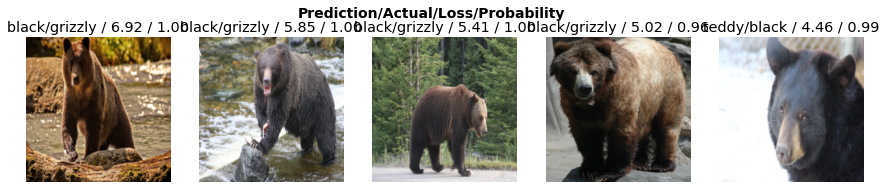

In [ ]:
interp.plot_top_losses(5, nrows=1)

- `plot_top_losses()` method shows what the errors actually look like.
- The first image was predicted to be a grizzly bear but the label was black bear
- The others are the ones that the model was least confident about.

# Training your model and using it to clean your data

- In most cases it's easier to clean your data after you've come up with a model for it.

- fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` which allows you to choose a category and training vs validation set, view the highest loss images (in order), along with menus to allow any images to be selected for removal or relabelling.

- Highest loss images means the images the model is most likely to get wrong (least confident about).

In [ ]:
cleaner = ImageClassifierCleaner(learn)

In [ ]:
cleaner

- Once you've verified your images and removed the ones with the highest loss, run the below code to delete or change the classification

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
path = Path('bears')
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.699508,0.497702,0.214876,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.288436,0.439389,0.173554,01:43
1,0.211956,0.502208,0.173554,01:38
2,0.155758,0.533303,0.181818,01:37
3,0.122717,0.639529,0.206612,01:37


# Productionizing your model

## Using the model for inference

- We first export the model.

- Exporting creates a model.pkl file containing the architecture and all of the parameters of the model.

- This can be copied over to a server and treated as a predefined program.

- `Inference` - The process of using a trained model on new data in production

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# Create an inference learner by loading our learner back again
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

('teddy', tensor(2), tensor([0.0237, 0.1675, 0.8088]))

- `Vocab` - Stores the mapping of the class labels.

- The tensors in the prediction above only make sense once we know the ordering of the classes as can be seen below.

- The above code indicates in order; the activation for black bears, grizzly bears and teddy bears.

In [ ]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']